In [23]:
####
# @author: Nwamaka Nzeocha and Fabian Okeke
# @course: CS 5304/Data Science in the Wild
####

# Environment setup

**useful tensor flow notebook:**
 - http://bit.ly/1NjhcfQ
 - http://katbailey.github.io/post/neural-nets-in-python/
 - https://medium.com/@ilblackdragon/tensorflow-tutorial-part-1-c559c63c0cb1#.al2qi7pab

**libraries:**
 - pip install https://storage.googleapis.com/tensorflow/mac/tensorflow-0.8.0-py2-none-any.whl 

**dataset:**
 - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_tst.gz
 - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_val.gz
 - https://s3.amazonaws.com/giyengar-cs5304/a4_smvl_trn.gz

# Add libraries and relevant functions

In [2]:
import random
import os.path
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_svmlight_file
from tensorflow.contrib import learn

from time import time

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline



#############
# helper functions
#############
def exists(filepath):
    return os.path.exists(filepath)

def get_data(filepath):
    start = time()
    data = load_svmlight_file(filepath)
    print 'Loading duration(secs):', time() - start
    return data[0].toarray(), data[1]

def get_best_params(model, training_data, test_data):
    """
    Find the best hyper parameters for model given the training and test data
    
    
    Parameters
    -----
    model: machine learning model such as Logistic Regression, MultiLayer Perceptron
    
    training_data: list containing X,y training data
    
    test_data: list containing test X,y test data
    
    
    Returns
    ------
    y_predicted, y_test, accuracy, auc, brier_loss
    """
    
    # choose model
    if model == "LR":
        model = LogisticRegression()
    elif model == "TF":
        model = learn.TensorFlowDNNClassifier(hidden_units=[10, 20], n_classes=2, steps=10, batch_size=100)     
    
    # fit & predict
    X_train, y_train = training_data
    X_test, y_test = test_data

    start = time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
  
    # compute accuracy, auc
    accuracy = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    
    print 'Accuracy: {0:f}'.format(accuracy)
    print 'AUC: {0:f}'.format(auc)
    
    # compute brier loss
    y_prob = model.predict_proba(X_test)[:,1] 
    brier_loss = metrics.brier_score_loss(y_test, y_prob, pos_label=1)

    print 'Model computation duration (secs):', time() - start
    return (y_pred, y_test, accuracy, auc, brier_loss)

/Users/fnokeke/dev/cs5304/deepLearning/skflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Split training data into smaller files

In [211]:
if not exists('trainingaa'):
    !wc -l 100000 'a4_smvl_trn' training
else:
    print 'training file already split.'

training file already split


# Logistic Regression partial fit

In [147]:
# get all training files
debug = False
if debug: 
    cwd = os.getcwd()
    tr_files = [f for f in os.listdir(cwd) if 'training' in f]

    # create model
    lr = SGDClassifier(loss="log")
    classes = [1, -1]

    start = time()
    for f in tr_files:
        X_train, y_train = get_data(f)
        lr.partial_fit(X_train, y_train, classes=classes)
        print '%s finished...' % f
    print 'All completed.'
    print 'Spent time:', time() - star
else:
    print "still debuggin'"

still debuggin'


# Load small training and test

In [4]:
X_train, y_train = get_data('trainSmall')

Loading duration(secs): 1.90114998817


In [5]:
X_test, y_test = get_data('vaSmall')

Loading duration(secs): 1.63670301437


# Get results for LR

In [8]:
results_LR = get_best_params("LR", [X_train, y_train], [X_test, y_test])
print "****Results_LR done****"

Accuracy: 0.922660
AUC: 0.880379
Model computation duration (secs): 114.245299101
****Results_LR done****


# Get results for Tensor Flow MLP

In [6]:
results_TF = get_best_params("TF", [X_train, y_train], [X_test, y_test])
print "****Results_TF done****"

Accuracy: 0.800920
AUC: 0.500000
Model computation duration (secs): 78.8194282055
****Results_TF done****


# ROC curves, Brier Score, Accuracy scores, AUC scores

/Users/fnokeke/dev/cs5304/deepLearning/skflow/lib/python2.7/site-packages/sklearn/metrics/ranking.py:530: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


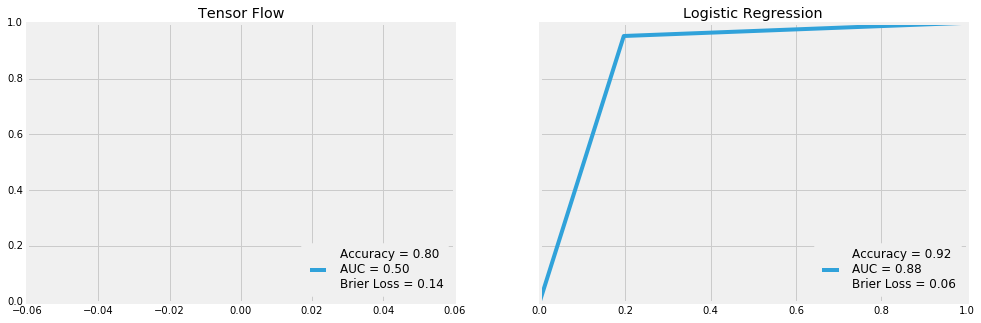

In [9]:
y_predictions = {
    'Logistic Regression': results_LR,
    'Tensor Flow': results_TF
}

fig, axes = plt.subplots(1, len(y_predictions), sharey=True)
fig.set_size_inches(15,5)
i = 0

for title, results in y_predictions.items():
    y_pred, y_va, accuracy, auc, brier_loss = results
    
    fpr, tpr, thresholds = metrics.roc_curve(y_pred, y_va, pos_label=1)
    
    label = 'Accuracy = %0.2f \nAUC = %0.2f \nBrier Loss = %0.2f' % (accuracy, auc, brier_loss)
    axes[i].plot(fpr, tpr, label=label)
    axes[i].set_title(title)
    axes[i].legend(loc='lower right')
    i += 1

In [7]:
help(learn.TensorFlowDNNClassifier)

Help on class TensorFlowDNNClassifier in module tensorflow.contrib.learn.python.learn.estimators.dnn:

class TensorFlowDNNClassifier(tensorflow.contrib.learn.python.learn.estimators.base.TensorFlowEstimator, sklearn.base.ClassifierMixin)
 |  TensorFlow DNN Classifier model.
 |  
 |  Parameters:
 |      hidden_units: List of hidden units per layer.
 |      n_classes: Number of classes in the target.
 |      batch_size: Mini batch size.
 |      steps: Number of steps to run over data.
 |      optimizer: Optimizer name (or class), for example "SGD", "Adam",
 |                 "Adagrad".
 |      learning_rate: If this is constant float value, no decay function is used.
 |          Instead, a customized decay function can be passed that accepts
 |          global_step as parameter and returns a Tensor.
 |          e.g. exponential decay function:
 |          def exp_decay(global_step):
 |              return tf.train.exponential_decay(
 |                  learning_rate=0.1, global_step,
 | 

In [39]:
import itertools

learning_rates = [0.3, 30.0, 300.0]
optimizers = ['Adam', 'Adagrad']
best_rate, best_optz, best_auc, acc, model_TF = None, None, None, None, None

start = time()
for params in itertools.product(learning_rates, optimizers):
    rate, optz = params    
    try:
        model_TF = learn.TensorFlowDNNRegressor(hidden_units=[10, 20], n_classes=2, steps=5, batch_size=32, 
                                                learning_rate=rate, optimizer=optz)
        model_TF.fit(X_train, y_train)
        y_pred = model_TF.predict(X_test)

        accuracy = metrics.accuracy_score(y_test, y_pred)
        auc = metrics.roc_auc_score(y_test, y_pred)
        
        print 'params:', params, 'acc:', accuracy, 'auc:', auc
        
        if best_auc == None or best_auc < auc:
            best_rate, best_optz, best_auc, acc  = rate, optz, auc, accuracy
            
    except Exception as err:
        print 'Unexpected error:', err

print
print 'Time spent(secs):', time() - start

print 'Done!'
print 'Best rate: %f\nBest optimizer: "%s"\nBest auc: %f\nAcc: %f' % (best_rate, best_optz, best_auc, acc)

params: (0.3, 'Adam') acc: 0.6843 auc: 0.561431386975
params: (0.3, 'Adagrad') acc: 0.7637 auc: 0.5
params: (30.0, 'Adam') acc: 0.6798 auc: 0.525264721481
params: (30.0, 'Adagrad') acc: 0.0 auc: 0.5
params: (300.0, 'Adam') acc: 0.7637 auc: 0.5
params: (300.0, 'Adagrad') acc: 0.7637 auc: 0.5

Time spent(secs): 33.819133997
Done!
Best rate: 0.300000
Best optimizer: "Adam"
Best auc: 0.561431
Acc: 0.684300
